In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,)
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
%matplotlib inline 

In [2]:
X_full = pd.read_csv('/Users/levashev/Desktop/METABRIC_RNA_Mutation.csv', low_memory=False)

In [3]:
clinical_df = X_full.iloc[:, :31]

In [4]:
clinical_df_inverted = clinical_df.copy()
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])

In [5]:
KM_df = clinical_df_inverted.copy()

In [6]:
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)

In [7]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code', 'death_from_cancer'], axis=1, inplace=True)

In [8]:
X = KM_df.copy()
X.drop(['overall_survival', 'overall_survival_months'], axis=1, inplace=True)

In [10]:
y = KM_df.copy()
y.drop(['age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index','pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage'], axis=1, inplace=True)

In [11]:
y_rear = y[['overall_survival', 'overall_survival_months']]

In [20]:
new_y = y_rear[['overall_survival', 'overall_survival_months']].to_numpy()

In [21]:
#Делаем структурированный массив
dt=dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')]

#Structured array
struct_y = np.array([tuple(row) for row in new_y], dtype=dt)
struct_y

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')])

In [22]:
num_columns = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]
print(num_columns)

['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'radio_therapy', 'tumor_size', 'tumor_stage']


In [23]:
cat_columns = [cname for cname in X.columns if
                    X[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype']


In [24]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

In [25]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [27]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(X)
X_pandas

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
0,1.122359,-0.512445,0.897956,0.788547,1.960788,-0.171942,1.757557,0.821330,-0.279656,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,2.0
1,-1.379317,-0.512445,0.897956,0.788547,-0.490841,-0.911280,-0.011378,0.821330,-1.071371,-1.193646,...,1.0,1.0,2.0,0.0,0.0,1.0,4.0,1.0,1.0,0.0
2,-0.941562,1.951430,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,-1.217538,-0.741490,0.396748,...,1.0,1.0,2.0,0.0,0.0,1.0,3.0,1.0,1.0,NaN
3,-1.033275,1.951430,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.821330,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,4.0,1.0,10.0,1.0,1.0,NaN
4,1.224091,1.951430,0.897956,0.788547,1.470462,-0.911280,1.789021,0.821330,0.907918,0.396748,...,1.0,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-1.386253,-0.512445,0.897956,0.788547,-0.245678,-0.418388,0.888821,0.821330,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0
1900,-1.403208,-0.512445,0.897956,-1.268156,-0.245678,0.074504,0.880081,0.821330,-0.411608,0.396748,...,1.0,1.0,0.0,1.0,0.0,1.0,6.0,NaN,0.0,NaN
1901,0.139723,-0.512445,0.897956,0.788547,10.541487,-0.418388,1.762801,0.821330,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1902,0.005622,-0.512445,-0.639479,0.788547,2.451113,2.292516,0.888821,-1.217538,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0


In [31]:
X_pandas = X_pandas.fillna(X_pandas.median())

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_pandas, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [43]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=42)

In [44]:
rsf.score(X_test, y_test)

0.7126262331445917

In [45]:
X_test_sorted = X_test.sort_values(by=["num__tumor_stage", "num__nottingham_prognostic_index"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
144,-0.487623,-0.512445,0.897956,0.788547,-0.490841,1.799625,-2.626326,-1.217538,-0.807466,-1.193646,...,1.0,1.0,2.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0
793,-0.058346,-0.512445,0.897956,-1.268156,-0.490841,0.813841,-2.615838,0.821330,-0.411608,-1.193646,...,1.0,1.0,2.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0
156,1.187097,-0.512445,0.897956,0.788547,-0.490841,-1.157725,-2.603603,-1.217538,0.050226,-1.193646,...,1.0,1.0,2.0,0.0,4.0,0.0,8.0,0.0,1.0,1.0
299,0.001768,1.951430,0.897956,0.788547,0.980136,-0.418388,1.893898,0.821330,4.866498,1.987143,...,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
5,1.362816,-0.512445,0.897956,0.788547,-0.490841,-0.418388,0.025329,0.821330,0.314131,3.577537,...,1.0,1.0,2.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0
254,-0.370477,1.951430,0.897956,0.788547,-0.000515,-0.911280,0.897561,-1.217538,0.248155,3.577537,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
pd.Series(rsf.predict(X_test_sel))

0    183.353091
1    205.607839
2    463.243679
3    808.629182
4    685.922291
5    492.304186
dtype: float64

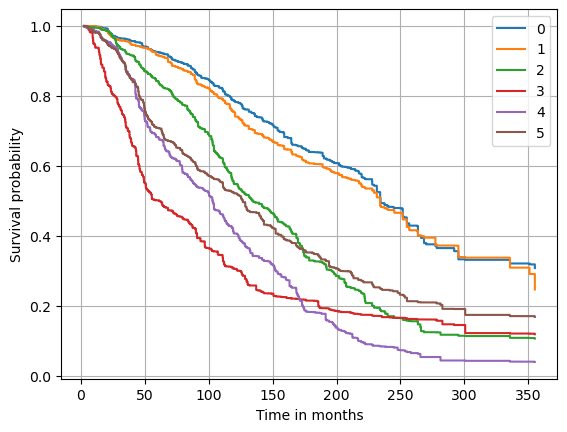

In [47]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)

Permutation-based feature importance

In [49]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=42
)

In [50]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
num__age_at_diagnosis,0.065319,0.012908
num__lymph_nodes_examined_positive,0.023484,0.005761
num__nottingham_prognostic_index,0.018623,0.005004
num__tumor_size,0.007129,0.003383
num__tumor_stage,0.003379,0.001702
cat__her2_status_measured_by_snp6,0.002178,0.001157
cat__primary_tumor_laterality,0.001554,0.000750
cat__pr_status,0.001001,0.001522
cat__pam50_+_claudin-low_subtype,0.000909,0.001650
num__radio_therapy,0.000773,0.001315


Градиентный бустинг

In [51]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [61]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=15, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.706


In [56]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 25):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

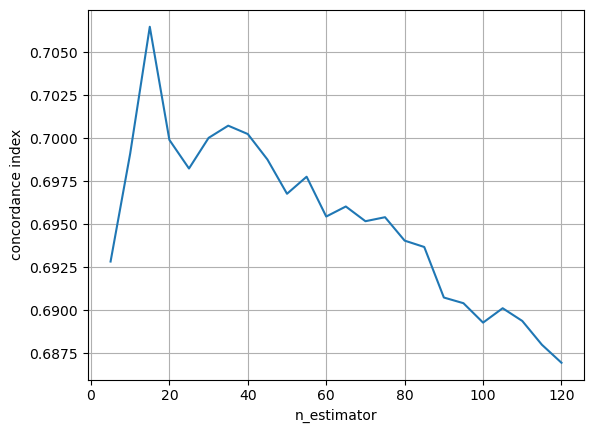

In [57]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)